# Quelques exemples de modeles existants

Regardons ici quelques exemples de modeles existants, disponibles sur HuggingFace, et utilisons-les en mode zero-shot.

On commence par importer les librairies necessaires :

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import requests
import torch
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Depth estimation avec Depth-Anything

In [2]:
image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-large-hf", use_fast=False)
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-large-hf")
model.to(DEVICE)

DepthAnythingForDepthEstimation(
  (backbone): Dinov2Backbone(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-23): 24 x Dinov2Layer(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2SdpaAttention(
            (attention): Dinov2SdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0

On peut afficher le nombre de parametres du modele :

In [3]:
print(f"Number of parameters in the model: {sum(p.numel() for p in model.parameters())}")

Number of parameters in the model: 335315649


On peut tester le modele avec une image COCO classique

In [4]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

La syntaxe est standard pour appeler les modeles de vision charges via transformers :

In [5]:
inputs = image_processor(images=image, return_tensors="pt").to(DEVICE)

On lance ensuite l'inference :

In [6]:
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

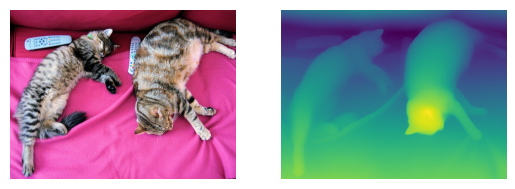

In [8]:
# On interpole a la taille de l'image d'origine
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# Puis on affiche les resultats
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[1].imshow(prediction.squeeze().cpu().numpy(), cmap='viridis')
ax[0].axis('off')
ax[1].axis('off')
plt.show()

On peut egalement tester le modele avec une image satellite

In [ ]:
image = Image.open('data/image_batiment_2.png')
inputs = image_processor(images=image, return_tensors="pt")#.to(DEVICE)
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[1].imshow(prediction.squeeze(), cmap='viridis')
ax[0].axis('off')
ax[1].axis('off')
plt.show()

### Depth estimation avec DepthPro

DepthPro est un modele de depth estimation recemment developpe par Apple. Le papier correspondant est disponible a [ce lien](https://arxiv.org/pdf/2410.02073).


2.2050133 3.0824778


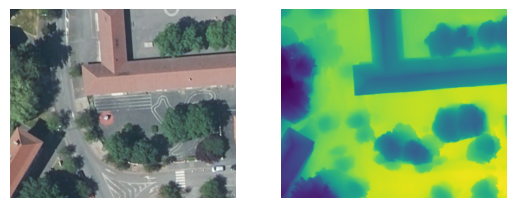

In [10]:
import requests
from PIL import Image
import matplotlib.pyplot as plt
import torch
from transformers import DepthProImageProcessorFast, DepthProForDepthEstimation

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

image_processor = DepthProImageProcessorFast.from_pretrained("apple/DepthPro-hf")
model = DepthProForDepthEstimation.from_pretrained("apple/DepthPro-hf").to(DEVICE)

image = Image.open('data/image_batiment_2.png')

inputs = image_processor(images=image, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = model(**inputs)

post_processed_output = image_processor.post_process_depth_estimation(
    outputs, target_sizes=[(image.height, image.width)],
)

field_of_view = post_processed_output[0]["field_of_view"]
focal_length = post_processed_output[0]["focal_length"]
depth_tensor = post_processed_output[0]["predicted_depth"]

# Conversion du tenseur en tableau NumPy
depth_np = depth_tensor.detach().cpu().numpy()
print(depth_np.min(), depth_np.max())

# Mise à l'échelle du tableau de profondeur
min_val, max_val = depth_np.min(), depth_np.max()
depth_rescaled = (depth_np - min_val) / (max_val - min_val)
depth_rescaled = (depth_rescaled * 255).astype("uint8")

# Conversion du tableau en image PIL
depth_img = Image.fromarray(depth_rescaled)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[1].imshow(depth_img, cmap='viridis')
ax[0].axis('off')
ax[1].axis('off')
plt.show()


### Zero-shot segmentation avec SAM

On va a present regarder le modele SAM (Segment Anything Model) developpe par Meta, et qui permet de faire de la zero-shot segmentation sur des images. Ici, on charge la version basee sur un ViT-B/16.

In [2]:
from transformers import SamModel, SamProcessor
model = SamModel.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
model.to(DEVICE)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

On charge notre image :

In [3]:
raw_image = Image.open('data/image_batiment_2.png')

La pipeline de traitement est un peu plus compliquee dans le cas de SAM, car le modele fonctionne sur la base d'**anchor points** (points de reference) pour calculer les masques.

In [4]:
input_points = [[[325, 195]]]

inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(DEVICE)
outputs = model(**inputs)
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())

/opt/conda/lib/python3.12/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


Par defaut, le modele retourne 3 masques, correspondant a 3 profondeurs de masque differentes.

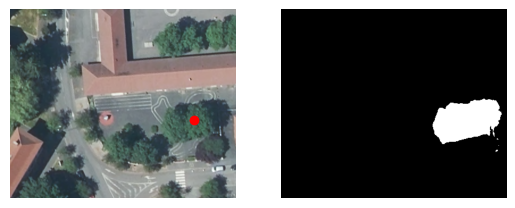

In [5]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(raw_image)
ax[0].scatter(input_points[0][0][0], input_points[0][0][1], color='red', marker='o')
ax[1].imshow(masks[0][0, 1].float().cpu().numpy(), cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
plt.show()